<!--COURSE_INFORMATION-->
<img align="left" style="padding-right:10px;" src="https://sitejerk.com/images/google-earth-logo-png-5.png" width=5% >
<img align="right" style="padding-left:10px;" src="https://colab.research.google.com/img/colab_favicon_256px.png" width=6% >


>> *This notebook is part of the free course [EEwPython](https://colab.research.google.com/github/csaybar/EEwPython/blob/master/index.ipynb); the content is available [on GitHub](https://github.com/csaybar/EEwPython)* and released under the [Apache 2.0 License](https://www.gnu.org/licenses/gpl-3.0.en.html). 99% of this material has been adapted from [Google Earth Engine Guides](https://developers.google.com/earth-engine/).

<!--NAVIGATION-->
 < [Image](2_eeImage.ipynb) | [Contents](index.ipynb) |  [Geometry, Feature and FeatureCollection](4_features.ipynb)>

<a href="https://colab.research.google.com/github/csaybar/EEwPython/blob/master/3_eeImageCollection.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>

<center>
<h1>Google Earth Engine with Python </h1>
<h2> ee.ImageCollection</h2>
</center>
<h2> Topics:</h2>

1. ImageCollection Overview
2. ImageCollection Information and Metadata
3. Filtering and ImageCollection
4. Mapping over an ImageCollection
5. Reducing an ImageCollection
6. Compositing and Mosaicking
7. Iterating over an ImageCollection


An **ImageCollection** is a stack or time series of images. In addition to loading an **ImageCollection** using an Earth Engine collection ID, Earth Engine has methods to create image collections. The constructor **ee.ImageCollection()** or the convenience method **ee.ImageCollection.fromImages()** create image collections from lists of images. You can also create new image collections by merging existing collections.

## Connecting GEE with Google Services

- **Authenticate to Earth Engine**

In [0]:
!pip install earthengine-api #earth-engine Python API

In [0]:
!earthengine authenticate 

- **Authenticate to Google Drive (OPTIONAL)**

In [0]:
from google.colab import drive
drive.mount('/content/drive')

- **Authenticate to Google Cloud (OPTIONAL)**

In [0]:
from google.colab import auth
auth.authenticate_user()

## Testing the software setup




In [0]:
# Earth Engine Python API
import ee
ee.Initialize()

In [4]:
import folium

# Define the URL format used for Earth Engine generated map tiles.
EE_TILES = 'https://earthengine.googleapis.com/map/{mapid}/{{z}}/{{x}}/{{y}}?token={token}'

print('Folium version: ' + folium.__version__)

Folium version: 0.8.3


In [0]:
#@title Mapdisplay: Display GEE objects using folium.
def Mapdisplay(center, dicc, Tiles="OpensTreetMap",zoom_start=10):
    '''
    :param center: Center of the map (Latitude and Longitude).
    :param dicc: Earth Engine Geometries or Tiles dictionary
    :param Tiles: Mapbox Bright,Mapbox Control Room,Stamen Terrain,Stamen Toner,stamenwatercolor,cartodbpositron.
    :zoom_start: Initial zoom level for the map.
    :return: A folium.Map object.
    '''
    mapViz = folium.Map(location=center,tiles=Tiles, zoom_start=zoom_start)
    for k,v in dicc.items():
      if ee.image.Image in [type(x) for x in v.values()]:
        folium.TileLayer(
            tiles = v["tile_fetcher"].url_format,
            attr  = 'Google Earth Engine',
            overlay =True,
            name  = k
          ).add_to(mapViz)
      else:
        folium.GeoJson(
        data = v,
        name = k
          ).add_to(mapViz)
    mapViz.add_child(folium.LayerControl())
    return mapViz

# 1. Image Collection Overview

An `ImageCollection` is a **stack or time series of images**. In addition to loading an `ImageCollection` using an Earth Engine collection ID, Earth Engine has methods to create image collections. The constructor `ee.ImageCollection()` or the convenience method `ee.ImageCollection.fromImages()` create image collections from lists of images. You can also create new image collections by merging existing collections. For example:


In [0]:
# Create arbitrary constant images.
constant1 = ee.Image(1)
constant2 = ee.Image(2)

# Create a collection by giving a list to the constructor.
collectionFromConstructor = ee.ImageCollection([constant1, constant2])
print('collectionFromConstructor: ')
collectionFromConstructor.getInfo()

In [0]:
# Create a collection with fromImages().
collectionFromImages = ee.ImageCollection.fromImages([ee.Image(3), ee.Image(4)])
print('collectionFromImages: ')
collectionFromImages.getInfo()

In [0]:
# Merge two collections.
mergedCollection = collectionFromConstructor.merge(collectionFromImages)
print('mergedCollection: ')
mergedCollection.getInfo()

In [0]:
# Create a toy FeatureCollection
features = ee.FeatureCollection(
  [ee.Feature(None, {'foo': 1}), ee.Feature(None, {'foo': 2})])

# Create an ImageCollection from the FeatureCollection
# by mapping a function over the FeatureCollection.
images = features.map(lambda feature:ee.Image(ee.Number(feature.get('foo'))))

# Print the resultant collection.
print('Image collection: ')
images.getInfo()

Note that in this example an `ImageCollection` is created by mapping a function that returns an `Image` over a `FeatureCollection`. Learn more about mapping in the [Mapping over an ImageCollection section](https://developers.google.com/earth-engine/ic_mapping). Learn more about feature collections from the [FeatureCollection section](https://developers.google.com/earth-engine/feature_collections).

# 2. ImageCollection Information and Metadata

As with Images, there are a variety of ways to get information about an ImageCollection. The collection can be printed directly to the console, but the console printout is **limited to 5000 elements**. Collections larger than 5000 images will need to be filtered before printing. Printing a large collection will be correspondingly slower. The following example shows various ways of getting information about image collections programmatically.

In [0]:
# Load a Landsat 8 ImageCollection for a single path-row.
collection = ee.ImageCollection('LANDSAT/LC08/C01/T1_TOA')\
               .filter(ee.Filter.eq('WRS_PATH', 44))\
               .filter(ee.Filter.eq('WRS_ROW', 34))\
               .filterDate('2014-03-01', '2014-08-01')
print('Collection: ')
collection.getInfo()

In [0]:
# Get the number of images.
count = collection.size()
print('Count: ', count.getInfo())

In [0]:
from datetime import datetime as dt
# Get the date range of images in the collection.
rango = collection.reduceColumns(ee.Reducer.minMax(), ["system:time_start"])

# Passing numeric date to standard
init_date = ee.Date(rango.get('min')).getInfo()['value']/1000.
init_date_f = dt.utcfromtimestamp(init_date).strftime('%Y-%m-%d %H:%M:%S')

last_date = ee.Date(rango.get('max')).getInfo()['value']/1000.
last_date_f = dt.utcfromtimestamp(last_date).strftime('%Y-%m-%d %H:%M:%S')

print('Date range: ',init_date_f,' - ',last_date_f)

In [0]:
# Get statistics for a property of the images in the collection.
sunStats = collection.aggregate_stats('SUN_ELEVATION')
print('Sun elevation statistics: ')
sunStats.getInfo()

In [0]:
# Sort by a cloud cover property, get the least cloudy image.
image = ee.Image(collection.sort('CLOUD_COVER').first())
print('Least cloudy image: ', )
image.getInfo()

In [0]:
# Limit the collection to the 10 most recent images.
recent = collection.sort('system:time_start', False).limit(10)
print('Recent images: ')
recent.getInfo()

# 3. Filtering an ImageCollection

As illustrated in the Get Started section and the ImageCollection Information section, Earth Engine provides a variety of convenience methods for filtering image collections. Specifically, many common use cases are handled by **imageCollection.filterDate()**, and **imageCollection.filterBounds()**. For general purpose filtering, use **imageCollection.filter()** with an **ee.Filter** as an argument. The following example demonstrates both convenience methods and **filter()** to identify and remove images with bad registration from an **ImageCollection**.

In [7]:
# Load Landsat 5 data, filter by date and bounds.
collection = ee.ImageCollection('LANDSAT/LT05/C01/T2').filterDate('1987-01-01', '1990-05-01').filterBounds(ee.Geometry.Point(25.8544, -18.08874))

# Also filter the collection by the IMAGE_QUALITY property.
filtered = collection.filterMetadata('IMAGE_QUALITY', 'equals', 9)

# Create two composites to check the effect of filtering by IMAGE_QUALITY.
badComposite = ee.Algorithms.Landsat.simpleComposite(collection, 75, 3)
goodComposite = ee.Algorithms.Landsat.simpleComposite(filtered, 75, 3)

dicc = {
    'Bad composite' : badComposite.getMapId({'bands': ['B3', 'B2', 'B1'], 'gain': 3.5}),
    'Good composite': goodComposite.getMapId({'bands': ['B3', 'B2', 'B1'], 'gain': 3.5})
}

# Display the results
center = [-18.08874, 25.8544]
Mapdisplay(center, dicc, zoom_start= 13)

# 4. Mapping over an ImageCollection

To apply a function to every Image in an ImageCollection use imageCollection.map(). The only argument to map() is a function which takes one parameter: an ee.Image. For example, the following code adds a timestamp band to every image in the collection.

In [0]:
from pprint import pprint
# Load a Landsat 8 collection for a single path-row.
collection = ee.ImageCollection('LANDSAT/LC08/C01/T1_TOA').filter(ee.Filter.eq('WRS_PATH', 44)).filter(ee.Filter.eq('WRS_ROW', 34))

# This function adds a band representing the image timestamp.
def addTime(image):
	return image.addBands(image.metadata('system:time_start'))

# Map the function over the collection and display the result.
pprint(collection.map(addTime).limit(3).getInfo())

Note that in the predefined function, the **metadata()** method is used to create a new Image from the value of a property. As discussed in the *Reducing* and *Compositing* sections, having that time band is useful for the linear modeling of change and for making composites.

The mapped function is limited in the operations it can perform. Specifically, it can’t modify variables outside the function; it can’t print anything; it can’t use JavaScript ‘if’ or ‘for’ statements. However, you can use **ee.Algorithms.If()** to perform conditional operations in a mapped function.

In [0]:
# Load a Landsat 8 collection for a single path-row.
collection = ee.ImageCollection('LANDSAT/LC8_L1T_TOA').filter(ee.Filter.eq('WRS_PATH', 44)).filter(ee.Filter.eq('WRS_ROW', 34))

# This function uses a conditional statement to return the image if
# the solar elevation > 40 degrees.  Otherwise it returns a zero image.
def conditional(image):
	return ee.Algorithms.If(ee.Number(image.get('SUN_ELEVATION')).gt(40), image, ee.Image(0))

# Map the function over the collection, convert to a List and print the result.
print('Expand this to see the result: ')
pprint(collection.map(conditional).limit(3).getInfo())

Inspect the list of images in the output ImageCollection and note that the when the condition evaluated by the **If()** algorithm is true, the output contains a constant image. Although this demonstrates a server-side conditional function (learn more about client vs. server in Earth Engine on this page), avoid **If()** in general and use filters instead.

# 5. Reducing an ImageCollection

To composite images in an **ImageCollection**, use **imageCollection.reduce()**. This will composite all the images in the collection to a single image representing, for example, the min, max, mean or standard deviation of the images. (See the Reducers section for more information about reducers). For example, to create a median value image from a collection:

In [8]:
# Load a Landsat 8 collection for a single path-row.
collection = ee.ImageCollection('LANDSAT/LC08/C01/T1_TOA').filter(ee.Filter.eq('WRS_PATH', 44)).filter(ee.Filter.eq('WRS_ROW', 34)).filterDate('2014-01-01', '2015-01-01')

# Compute a median image and display.
median = collection.median()

dicc = {
    'median' : median.getMapId({'bands': ['B4', 'B3', 'B2'], 'max': 0.3})
}

# Display the results
center = [37.7726, -122.3578]
Mapdisplay(center, dicc, zoom_start= 12)

At each location in the output image, in each band, the pixel value is the median of all unmasked pixels in the input imagery (the images in the collection). In the previous example, median() is a convenience method for the following call:

In [18]:
# Reduce the collection with a median reducer.
median = collection.reduce(ee.Reducer.median())

# Display the median image.
dicc = {'also median' : median.getMapId({'bands': ['B4_median', 'B3_median', 'B2_median'], 'max': 0.3})}

# Display the results
center = [37.7726, -122.3578]
Mapdisplay(center, dicc, zoom_start= 12)

Note that the band names differ as a result of using reduce() instead of the convenience method. Specifically, the names of the reducer have been appended to the band names.

More complex reductions are also possible using reduce(). For example, to compute the long term linear trend over a collection, use one of the linear regression reducers. The following code computes the linear trend of MODIS Enhanced Vegetation Index (EVI).

In [19]:
# This function adds a band representing the image timestamp.
def addTime(image):
  return image.addBands(image.metadata('system:time_start').divide(1000 * 60 * 60 * 24 * 365))

# Load a MODIS collection, filter to several years of 16 day mosaics, and map the time band function over it.
collection = ee.ImageCollection('MODIS/006/MYD13A1').filterDate('2004-01-01', '2010-10-31').map(addTime)

# Select the bands to model with the independent variable first.
# Compute the linear trend over time.
trend = collection.select(['system:time_start', 'EVI']).reduce(ee.Reducer.linearFit())

# Display the trend with increasing slopes in green, decreasing in red.
dicc = {
    'EVI trend' : trend.getMapId({'min': 0, 'max': [-100, 100, 10000], 'bands': ['scale', 'scale', 'offset']})
}

# Display the results
center = [39.436, -96.943]
Mapdisplay(center, dicc, zoom_start= 5)

Note that the output of the reduction in this example is a two banded image with one band for the slope of a linear regression (**scale**) and one band for the intercept (**offset**). Explore the API documentation to see a list of the reducers that are available to reduce an **ImageCollection** to a single Image. See the **ImageCollection.reduce()** section for more information about reducing image collections.



# 6. Compositing and Mosaicking

In general, compositing refers to the process of combining spatially overlapping images into a single image based on an aggregation function. Mosaicking refers to the process of spatially assembling image datasets to produce a spatially continuous image. In Earth Engine, these terms are used interchangeably, though both compositing and mosaicking are supported. For example, consider the task of compositing multiple images in the same location. For example, using one National Agriculture Imagery Program (NAIP) Digital Orthophoto Quarter Quadrangle (DOQQ) at different times, the following example demonstrates making a maximum value composite:

In [22]:
# Load three NAIP quarter quads in the same location, different times.
naip2004_2012 = ee.ImageCollection('USDA/NAIP/DOQQ')\
                  .filterBounds(ee.Geometry.Point(-71.08841, 42.39823))\
                  .filterDate('2004-07-01', '2012-12-31')\
                  .select(['R', 'G', 'B'])

# Temporally composite the images with a maximum value function.
composite = naip2004_2012.max()
center = [42.3712, -71.12532]
Mapdisplay(center, {'max value composite':composite.getMapId()},zoom_start=12)

Consider the need to mosaic four different DOQQs at the same time, but different locations. The following example demonstrates that using **imageCollection.mosaic()**:



In [23]:
# Load four 2012 NAIP quarter quads, different locations.
naip2012 = ee.ImageCollection('USDA/NAIP/DOQQ')\
             .filterBounds(ee.Geometry.Rectangle(-71.17965, 42.35125, -71.08824, 42.40584))\
             .filterDate('2012-01-01', '2012-12-31')

# Spatially mosaic the images in the collection and display.
mosaic = naip2012.mosaic()
center = [42.3712,-71.12532]
Mapdisplay(center,{'spatial mosaic':mosaic.getMapId()},zoom_start=12)

Note that there is some overlap in the DOQQs in the previous example. The **mosaic()** method composites overlapping images according to their order in the collection (last on top). To control the source of pixels in a mosaic (or a composite), use image masks. For example, the following uses thresholds on spectral indices to mask the image data in a mosaic:



In [49]:
# Load a NAIP quarter quad, display.
naip = ee.Image('USDA/NAIP/DOQQ/m_4207148_nw_19_1_20120710')

# Create the NDVI and NDWI spectral indices.
ndvi = naip.normalizedDifference(['N', 'R'])
ndwi = naip.normalizedDifference(['G', 'N'])

# Create some binary images from thresholds on the indices.
# This threshold is designed to detect bare land.
bare1 = ndvi.lt(0.2).And(ndwi.lt(0.3))
# This detects bare land with lower sensitivity. It also detects shadows.
bare2 = ndvi.lt(0.2).And(ndwi.lt(0.8));

# Define visualization parameters for the spectral indices.
ndviViz = {'min': -1, 'max': 1, 'palette': ['FF0000', '00FF00']}
ndwiViz = {'min': 0.5, 'max': 1, 'palette': ['00FFFF', '0000FF']}

# Mask and mosaic visualization images.  The last layer is on top.
mosaic = ee.ImageCollection([
  # NDWI > 0.5 is water.  Visualize it with a blue palette.
  ndwi.updateMask(ndwi.gte(0.5)).visualize(**ndwiViz),
  # NDVI > 0.2 is vegetation.  Visualize it with a green palette.
  ndvi.updateMask(ndvi.gte(0.2)).visualize(**ndviViz),
  # Visualize bare areas with shadow (bare2 but not bare1) as gray.
  bare2.updateMask(bare2.And(bare1.Not())).visualize(**{'palette': ['AAAAAA']}),
  # Visualize the other bare areas as white.
  bare1.updateMask(bare1).visualize(**{'palette': ['FFFFFF']}),
]).mosaic()

center = [42.3443, -71.0915]
dicc = {'NAIP DOQQ':naip.getMapId(),
        'Visualization mosaic':mosaic.getMapId()}
Mapdisplay(center,dicc,zoom_start=14)   

To make a composite which maximizes an arbitrary band in the input, use **imageCollection.qualityMosaic()**. The **qualityMosaic()** method sets each pixel in the composite based on which image in the collection has a maximum value for the specified band. For example, the following code demonstrates making a greenest pixel composite and a recent value composite:

In [52]:
# This function masks clouds in Landsat 8 imagery.
def maskClouds(img):
  scored = ee.Algorithms.Landsat.simpleCloudScore(img)
  return img.updateMask(scored.select(['cloud']).lt(20))


# This function masks clouds and adds quality bands to Landsat 8 images.
def addQualityBands(img):
  return maskClouds(img).addBands(img.normalizedDifference(['B5', 'B4']))\
                          .addBands(img.metadata('system:time_start')) # time in days


# Load a 2014 Landsat 8 ImageCollection.
# Map the cloud masking and quality band function over the collection.
collection = ee.ImageCollection('LANDSAT/LC08/C01/T1_TOA')\
               .filterDate('2014-06-01', '2014-12-31')\
               .map(addQualityBands)

# Create a cloud-free, most recent value composite.
recentValueComposite = collection.qualityMosaic('system:time_start')

# Create a greenest pixel composite.
greenestPixelComposite = collection.qualityMosaic('nd')


# Create a cloudy image in the collection.
cloudy = ee.Image('LANDSAT/LC08/C01/T1_TOA/LC08_044034_20140825');

# Display the results.
center = [37.8239, -122.374] # San Francisco Bay
vizParams = {'bands': ['B5', 'B4', 'B3'], 'min': 0, 'max': 0.4}
dicc = {'recent value composite':recentValueComposite.getMapId(vizParams),
        'greenest pixel composite':greenestPixelComposite.getMapId(vizParams),
        'cloudy':cloudy.getMapId(vizParams)}

Mapdisplay(center,dicc,zoom_start=12)

# 7. Iterating over an ImageCollection

Although `map()` applies a function to every image in a collection, the function visits every image in the collection independently. For example, suppose you want to compute a cumulative anomaly ($A_t$) at time t from a time series. To obtain a recursively defined series of the form $A_t = f(Image_t, A_{t-1})$, mapping won't work because the function (f) depends on the previous result ($A{t-1}$). 

For example, suppose you want to compute a series of cumulative Normalized Difference Vegetation Index (NDVI) anomaly images relative to a baseline. Let $A_0 = 0$ and $f(Image_t, A_{t-1}) = Image_t + A_{t-1}$ where $A_{t-1}$ is the cumulative anomaly up to time $t-1$ and Image_t is the anomaly at time t. Use **imageCollection.iterate()** to make this recursively defined ImageCollection. In the following example, the function **accumulate()** takes two parameters: an image in the collection, and a list of all the previous outputs. With each call to **iterate()**, the anomaly is added to the running sum and the result is added to the list. The final result is passed to the **ImageCollection** constructor to get a new sequence of images:


In [54]:
# Load MODIS EVI imagery.
collection = ee.ImageCollection('MODIS/006/MYD13A1').select('EVI');

# Define reference conditions from the first 10 years of data.
reference = collection.filterDate('2001-01-01', '2010-12-31')\
                      .sort('system:time_start', False) # Sort chronologically in descending order.

# Compute the mean of the first 10 years.
mean = reference.mean()

# Compute anomalies by subtracting the 2001-2010 mean from each image in a
# collection of 2011-2014 images. Copy the date metadata over to the
# computed anomaly images in the new collection.
series = collection.filterDate('2011-01-01', '2014-12-31')\
                   .map(lambda img: img.subtract(mean).set('system:time_start', img.get('system:time_start')))

# Display cumulative anomalies.
center = [40.2,-100.811]
vizParams = {'min': -60000, 'max': 60000, 'palette': ['FF0000', '000000', '00FF00']}
dicc = {'EVI anomaly':series.sum().getMapId(vizParams)}
Mapdisplay(center,dicc,zoom_start=5)

In [0]:
# Get the timestamp from the most recent image in the reference collection.
time0 = reference.first().get('system:time_start')

# Use imageCollection.iterate() to make a collection of cumulative anomaly over time.
# The initial value for iterate() is a list of anomaly images already processed.
# The first anomaly image in the list is just 0, with the time0 timestamp.
first = ee.List([ee.Image(0).set('system:time_start', time0).select([0], ['EVI'])]) # Rename the first band 'EVI'.

# This is a function to pass to Iterate().
# As anomaly images are computed, add them to the list.
def accumulate(img,lista):
  # Get the latest cumulative anomaly image from the end of the list with
  # get(-1).  Since the type of the list argument to the function is unknown,
  # it needs to be cast to a List.  Since the return type of get() is unknown,
  # cast it to Image.
  img = ee.Image(img)
  previous = ee.Image(ee.List(lista).get(-1))
  # Add the current anomaly to make a new cumulative anomaly image.
  added = img.add(previous)\
               .set('system:time_start', img.get('system:time_start')) # Propagate metadata to the new image.
  # Return the list with the cumulative anomaly inserted.
  return ee.List(lista).add(added)

# Create an ImageCollection of cumulative anomaly images by iterating.
# Since the return type of iterate is unknown, it needs to be cast to a List.
cumulative = ee.ImageCollection(ee.List(series.iterate(accumulate, first)))

In [0]:
def stackCollection(collection):
  # Create an initial image.
  first = ee.Image(collection.first()).select([])

  # Write a function that appends a band to an image.
  def appendBands(image, previous):
    return ee.Image(previous).addBands(image)
  return ee.Image(collection.iterate(appendBands, first))

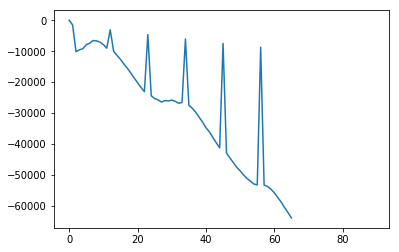

In [58]:
import numpy as np
import matplotlib.pyplot as plt

# Chart some interesting locations.
pt1 = ee.Geometry.Point(116.4647, 40.1054)

# ee.ImageCollection to ee.Image
img_cumulative = stackCollection(cumulative)


series = img_cumulative.reduceRegions(collection=pt1,
                                      reducer=ee.Reducer.mean(),
                                      scale=500)

dic_series = series.getInfo()
EVI_anom = np.array(list(dic_series['features'][0]['properties'].values()))

plt.plot(EVI_anom)
plt.show()

<!--NAVIGATION-->
 < [Image](2_eeImage.ipynb) | [Contents](index.ipynb) |  [Geometry, Feature and FeatureCollection](4_features.ipynb)>

<a href="https://colab.research.google.com/github/csaybar/EEwPython/blob/master/3_eeImageCollection.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>